# Load Libraries

In [1]:
library(data.table) # Fast CSV read
library(ggplot2)    #Visualisation
library(lubridate)  #Date-Time extraction
library(dplyr)      #Data wrangling
library(ranger) # Random forest
library(geosphere) #Dist
library(caret) #Cross vaildation
library(xgboost)
library(DataExplorer)
library(mlr)
library(gridExtra)


Attaching package: ‘lubridate’

The following objects are masked from ‘package:data.table’:

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following object is masked from ‘package:base’:

    date


Attaching package: ‘dplyr’

The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: lattice
Warning message:
“replacing previous import ‘ggplot2::empty’ by ‘plyr::empty’ when loading ‘caret’”
Attaching package: ‘xgboost’

The following object is masked from ‘package:dplyr’:

    slice

Loading required package: ParamHelpers

Attaching package: ‘mlr’

The following object is masked from ‘package:caret’:

    train


Attaching package: ‘g

# Read Data

In [2]:
train=fread("../input/train.csv",nrows=2000000)
test <- fread("../input/test.csv")

train= train  %>% mutate(sep="train")
test= test  %>% mutate(sep="test")

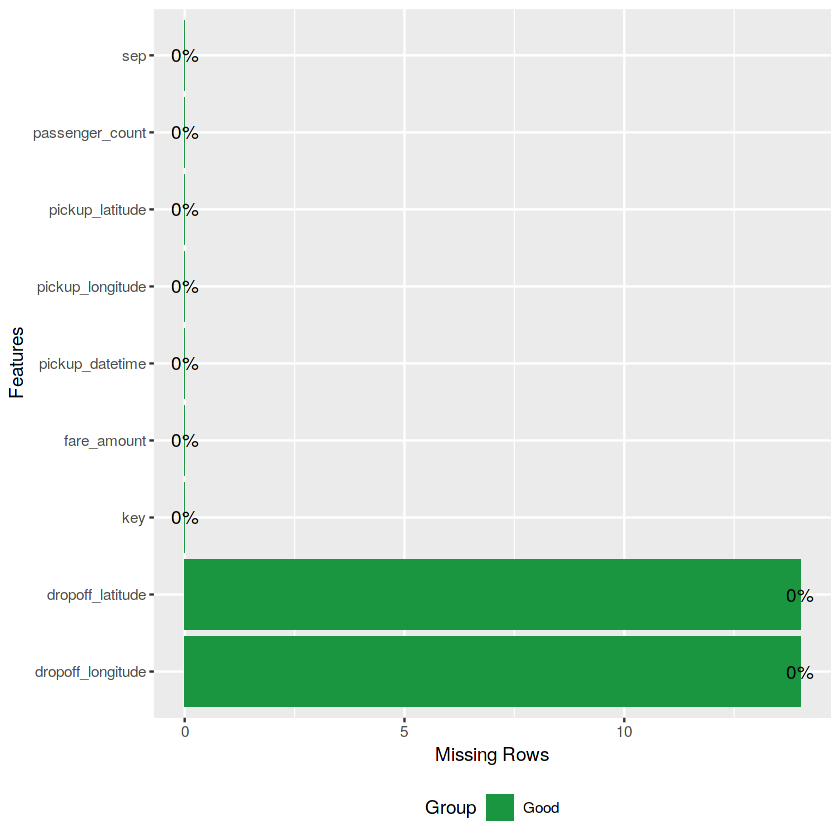

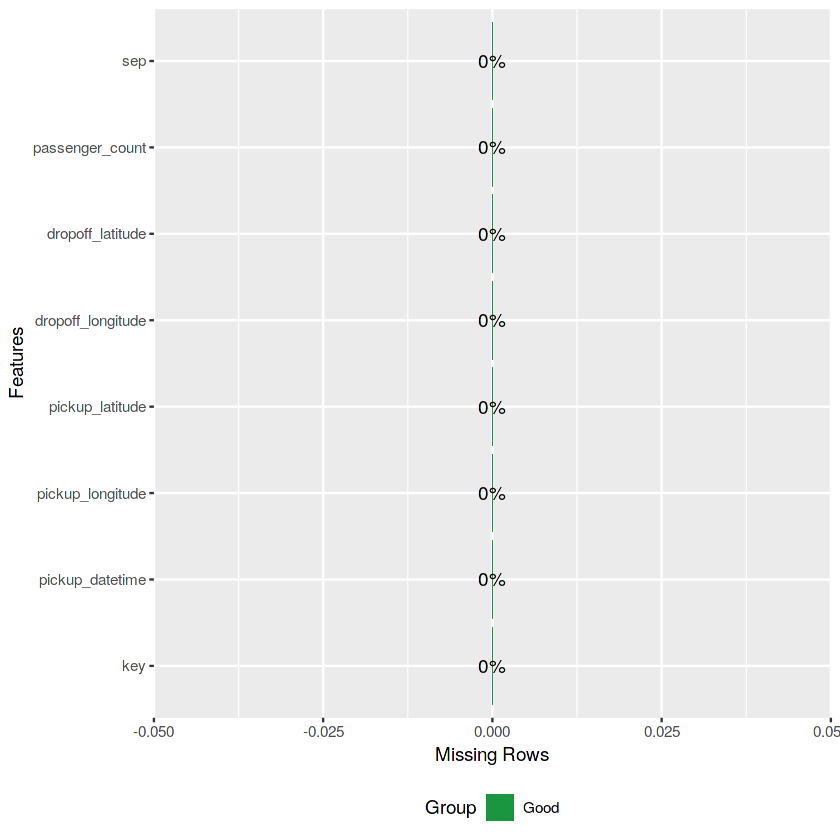

In [3]:
par(mfrow=c(2,1))
plot_missing(train)
plot_missing(test)

In [4]:
colSums(is.na(train))

key       fare_amount   pickup_datetime  pickup_longitude 
                0                 0                 0                 0 
  pickup_latitude dropoff_longitude  dropoff_latitude   passenger_count 
                0                14                14                 0 
              sep 
                0

In [5]:
summary(train)

     key             fare_amount      pickup_datetime    pickup_longitude  
 Length:2000000     Min.   : -62.00   Length:2000000     Min.   :-3377.68  
 Class :character   1st Qu.:   6.00   Class :character   1st Qu.:  -73.99  
 Mode  :character   Median :   8.50   Mode  :character   Median :  -73.98  
                    Mean   :  11.35                      Mean   :  -72.52  
                    3rd Qu.:  12.50                      3rd Qu.:  -73.97  
                    Max.   :1273.31                      Max.   : 2856.44  
                                                                           
 pickup_latitude    dropoff_longitude  dropoff_latitude   passenger_count  
 Min.   :-3458.66   Min.   :-3383.30   Min.   :-3461.54   Min.   :  0.000  
 1st Qu.:   40.73   1st Qu.:  -73.99   1st Qu.:   40.73   1st Qu.:  1.000  
 Median :   40.75   Median :  -73.98   Median :   40.75   Median :  1.000  
 Mean   :   39.93   Mean   :  -72.52   Mean   :   39.93   Mean   :  1.684  
 3rd Qu.:   

* fare amount has negative values.
* Inital charge of fare_amount is $2.5
* Latitude and Longitude: Max possible lat/long= 90, 180. 
* pasenger_count has 0 values and not possible 208

In [6]:
summary(test)

     key            pickup_datetime    pickup_longitude pickup_latitude
 Length:9914        Length:9914        Min.   :-74.25   Min.   :40.57  
 Class :character   Class :character   1st Qu.:-73.99   1st Qu.:40.74  
 Mode  :character   Mode  :character   Median :-73.98   Median :40.75  
                                       Mean   :-73.97   Mean   :40.75  
                                       3rd Qu.:-73.97   3rd Qu.:40.77  
                                       Max.   :-72.99   Max.   :41.71  
 dropoff_longitude dropoff_latitude passenger_count     sep           
 Min.   :-74.26    Min.   :40.57    Min.   :1.000   Length:9914       
 1st Qu.:-73.99    1st Qu.:40.74    1st Qu.:1.000   Class :character  
 Median :-73.98    Median :40.75    Median :1.000   Mode  :character  
 Mean   :-73.97    Mean   :40.75    Mean   :1.671                     
 3rd Qu.:-73.96    3rd Qu.:40.77    3rd Qu.:2.000                     
 Max.   :-72.99    Max.   :41.70    Max.   :6.000                     

# Data Cleansing

1. Delete the Missing Values, 

2. If fare amount is less than inital charge 2.5 then delete

3. Coordinate lat long from test lat,long max/min possible for what isn't an outlier. 

In [7]:
train<-na.omit(train)

train = train %>% 
  filter(fare_amount>=2.5,
         pickup_latitude<=41.71, pickup_latitude>=40.57,
         dropoff_latitude<=41.70, dropoff_latitude>=40.57,
         pickup_longitude<=-72.99, pickup_longitude>=-74.25,
         dropoff_longitude<=-72.99, dropoff_longitude>=-74.26)

In [8]:
dim(train)

[1] 1957409       9

In [9]:
full=bind_rows(train,test)
full$sep=as.factor(full$sep)

** Manhattan and Euclidean Distance**

https://en.wikipedia.org/wiki/Minkowski_distance
 
if p = 1, then this is the Manhattan distance and if p = 2 this is the Euclidean distance. 

In [10]:
minkowski_distance <- function(x1, x2, y1, y2, p) {
    return ((abs(x2 - x1)^p) + (abs(y2 - y1))^p)^(1 / p)
    }

In [11]:
full<-full%>%
  mutate(
    pickup_datetime = ymd_hms(pickup_datetime),
    year = as.factor(year(pickup_datetime)),
    month = as.factor(month(pickup_datetime)),
    day = as.numeric(day(pickup_datetime)),
    dayofweek = as.factor(wday(pickup_datetime)),
    hour = as.numeric(hour(pickup_datetime)),
    timeofday = as.factor(ifelse(hour >= 3 & hour < 9,
                    "Morning", ifelse(hour >= 9 & hour < 14, "Mid-Day",
                        ifelse(hour >= 14 & hour < 18, "Evening", "Night")))),
    lat_diff=abs(dropoff_latitude)-abs(pickup_latitude),
    long_diff=abs(dropoff_longitude)-abs(pickup_longitude),
    manhattan=minkowski_distance(pickup_longitude,dropoff_longitude,pickup_latitude,dropoff_latitude,1),
    ) %>% 
    select(-pickup_datetime)

In [12]:
full<-full%>%
  mutate(dist = distHaversine(cbind(pickup_longitude, pickup_latitude), cbind(dropoff_longitude, dropoff_latitude), r = 6371))

In [13]:
glimpse(full)

Observations: 1,967,323
Variables: 18
$ key               <chr> "2009-06-15 17:26:21.0000001", "2010-01-05 16:52:16…
$ fare_amount       <dbl> 4.5, 16.9, 5.7, 7.7, 5.3, 12.1, 7.5, 16.5, 9.0, 8.9…
$ pickup_longitude  <dbl> -73.84431, -74.01605, -73.98274, -73.98713, -73.968…
$ pickup_latitude   <dbl> 40.72132, 40.71130, 40.76127, 40.73314, 40.76801, 4…
$ dropoff_longitude <dbl> -73.84161, -73.97927, -73.99124, -73.99157, -73.956…
$ dropoff_latitude  <dbl> 40.71228, 40.78200, 40.75056, 40.75809, 40.78376, 4…
$ passenger_count   <int> 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 1, …
$ sep               <fct> train, train, train, train, train, train, train, tr…
$ year              <fct> 2009, 2010, 2011, 2012, 2010, 2011, 2012, 2012, 201…
$ month             <fct> 6, 1, 8, 4, 3, 1, 11, 1, 12, 9, 4, 11, 7, 4, 2, 7, …
$ day               <dbl> 15, 5, 18, 21, 9, 6, 20, 4, 3, 2, 8, 6, 2, 5, 19, 2…
$ dayofweek         <fct> 2, 3, 5, 7, 3, 5, 3, 4, 2, 4, 1, 6, 3, 3, 4, 4, 4, …
$ hour        

In [14]:
summary(full)

     key             fare_amount     pickup_longitude pickup_latitude
 Length:1967323     Min.   :  2.50   Min.   :-74.25   Min.   :40.57  
 Class :character   1st Qu.:  6.00   1st Qu.:-73.99   1st Qu.:40.74  
 Mode  :character   Median :  8.50   Median :-73.98   Median :40.75  
                    Mean   : 11.32   Mean   :-73.98   Mean   :40.75  
                    3rd Qu.: 12.50   3rd Qu.:-73.97   3rd Qu.:40.77  
                    Max.   :500.00   Max.   :-72.99   Max.   :41.71  
                    NA's   :9914                                     
 dropoff_longitude dropoff_latitude passenger_count    sep         
 Min.   :-74.26    Min.   :40.57    Min.   :0.000   test :   9914  
 1st Qu.:-73.99    1st Qu.:40.74    1st Qu.:1.000   train:1957409  
 Median :-73.98    Median :40.75    Median :1.000                  
 Mean   :-73.97    Mean   :40.75    Mean   :1.684                  
 3rd Qu.:-73.97    3rd Qu.:40.77    3rd Qu.:2.000                  
 Max.   :-72.99    Max.   :41.70

# Target Variable

https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page


https://www.kaggle.com/madhurisivalenka/cleansing-eda-modelling-lgbm-xgboost-starters

* A quick Google search gave me the following prices

* $$2.5 base-price + $1.56/km -- 6AM to 8PM Mon-Fri

* $$3.0 base-price + $1.56/km -- 8PM to 6AM Mon-Fri and Sat&Sun

In [15]:
summary(full$fare_amount)
quantile(full$fare_amount,.99,na.rm=T)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
   2.50    6.00    8.50   11.32   12.50  500.00    9914 

99% 
 52

In [16]:
full  %>% filter(fare_amount>52)  %>% count()

n
19415


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


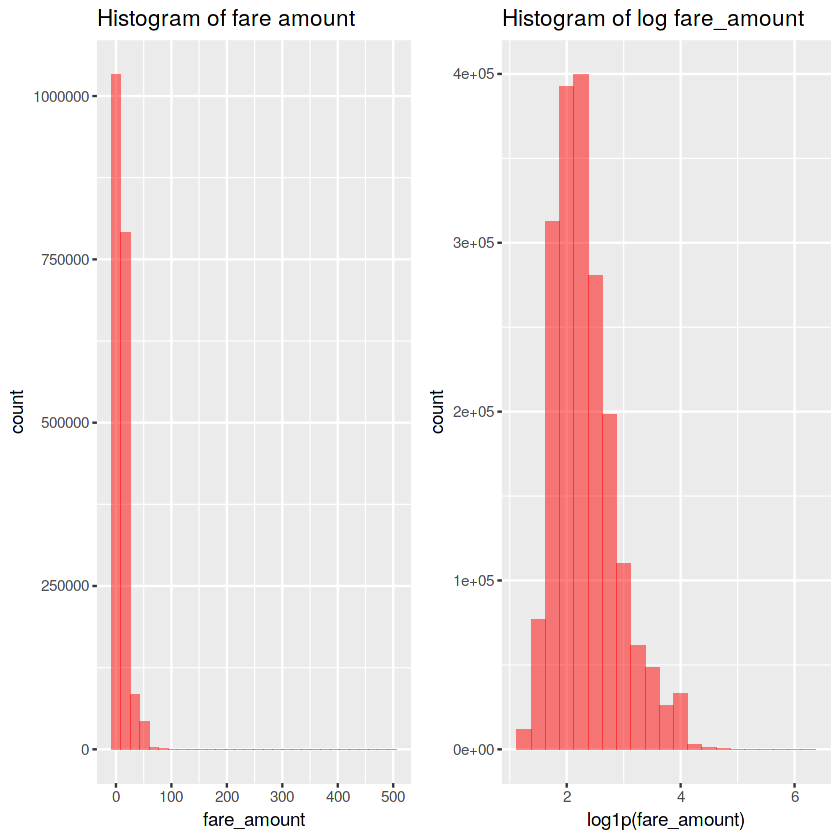

In [17]:
p1=ggplot(train,aes(x=fare_amount))+
    geom_histogram(fill="red",alpha=0.5) +
    ggtitle("Histogram of fare amount")
    

p2=ggplot(train,aes(x=log1p(fare_amount)))+
    geom_histogram(fill="red",alpha=0.5,binwidth=0.25)+
    ggtitle("Histogram of log fare_amount")

grid.arrange(p1,p2,ncol=2)

# Explanatory Variables

### (1) Lat, Long

In [18]:
summary(full[,c(3,4,5,6)])

 pickup_longitude pickup_latitude dropoff_longitude dropoff_latitude
 Min.   :-74.25   Min.   :40.57   Min.   :-74.26    Min.   :40.57   
 1st Qu.:-73.99   1st Qu.:40.74   1st Qu.:-73.99    1st Qu.:40.74   
 Median :-73.98   Median :40.75   Median :-73.98    Median :40.75   
 Mean   :-73.98   Mean   :40.75   Mean   :-73.97    Mean   :40.75   
 3rd Qu.:-73.97   3rd Qu.:40.77   3rd Qu.:-73.97    3rd Qu.:40.77   
 Max.   :-72.99   Max.   :41.71   Max.   :-72.99    Max.   :41.70   

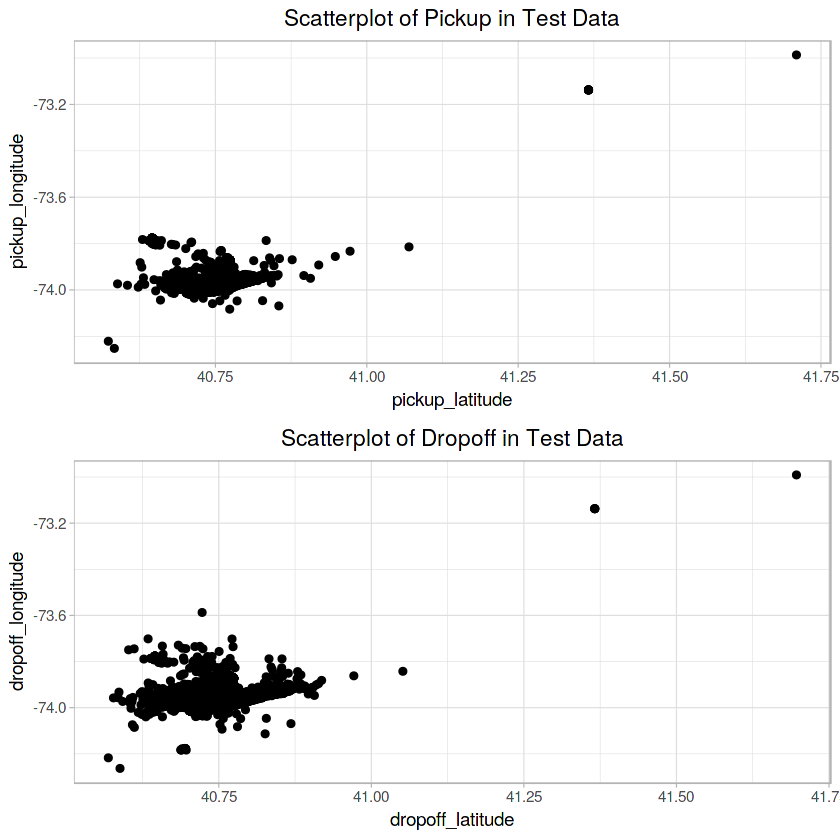

In [19]:
p1=full  %>%  filter(sep=="test") %>%
    ggplot(aes(x=pickup_latitude,y=pickup_longitude))+
    geom_point()+
    theme_light()+
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle("Scatterplot of Pickup in Test Data")


p2=full  %>%  filter(sep=="test") %>%
    ggplot(aes(x=dropoff_latitude,y=dropoff_longitude))+
    geom_point()+
    theme_light()+
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle("Scatterplot of Dropoff in Test Data")


grid.arrange(p1,p2,nrow=2)

In [20]:
full  %>% filter(sep=="test") %>% 
    filter(pickup_longitude>=c(-73.2))

key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,sep,year,month,day,dayofweek,hour,timeofday,lat_diff,long_diff,manhattan,dist
2009-11-24 08:58:48.0000006,NA,-73.13739,41.36614,-73.13739,41.36614,1,test,2009,11,24,3,8,Morning,0.000000,0.000000,0.000000,0.000000
2010-06-11 13:37:21.0000004,NA,-73.13739,41.36614,-73.98414,40.73293,1,test,2010,6,11,6,13,Mid-Day,-0.633213,0.846752,1.479965,99.996040
2010-05-06 11:35:26.0000003,NA,-73.13739,41.36614,-73.13739,41.36614,1,test,2010,5,6,5,11,Mid-Day,0.000000,0.000000,0.000000,0.000000
2010-07-04 16:44:11.0000002,NA,-73.13739,41.36614,-73.98263,40.76724,1,test,2010,7,4,1,16,Evening,-0.598898,0.845236,1.444134,97.240975
2009-06-04 19:34:15.0000001,NA,-73.13739,41.36614,-73.13739,41.36614,1,test,2009,6,4,5,19,Night,0.000000,0.000000,0.000000,0.000000
2012-01-26 07:33:00.000000181,NA,-72.98653,41.70956,-72.99096,41.69668,2,test,2012,1,26,5,7,Morning,-0.012872,0.004431,0.017303,1.477816
2009-07-30 15:49:15.0000002,NA,-73.13739,41.36614,-73.13739,41.36614,2,test,2009,7,30,5,15,Evening,0.000000,0.000000,0.000000,0.000000
2009-11-25 19:32:52.0000001,NA,-73.13739,41.36614,-73.98656,40.75797,3,test,2009,11,25,4,19,Night,-0.608172,0.849168,1.457340,98.192419


In [21]:
full  %>% filter(sep=="test") %>% 
    filter(dropoff_longitude>=c(-73.2))

key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,sep,year,month,day,dayofweek,hour,timeofday,lat_diff,long_diff,manhattan,dist
2009-11-24 08:58:48.0000006,NA,-73.13739,41.36614,-73.13739,41.36614,1,test,2009,11,24,3,8,Morning,0.000000,0.000000,0.000000,0.000000
2010-05-06 11:35:26.0000003,NA,-73.13739,41.36614,-73.13739,41.36614,1,test,2010,5,6,5,11,Mid-Day,0.000000,0.000000,0.000000,0.000000
2009-06-04 19:34:15.0000001,NA,-73.13739,41.36614,-73.13739,41.36614,1,test,2009,6,4,5,19,Night,0.000000,0.000000,0.000000,0.000000
2012-01-26 07:33:00.000000181,NA,-72.98653,41.70956,-72.99096,41.69668,2,test,2012,1,26,5,7,Morning,-0.012872,0.004431,0.017303,1.477816
2009-07-30 15:49:15.0000002,NA,-73.13739,41.36614,-73.13739,41.36614,2,test,2009,7,30,5,15,Evening,0.000000,0.000000,0.000000,0.000000


* In Test data, longtitude=-73.13739, latitude=41.36614 is so serious. almoust dist is 0 becasuse pickup is same with dropoff
  
  but Test data is unseen data, so we will discuss how to deal with same lat,long

In [22]:
full  %>% filter(pickup_latitude==dropoff_latitude)   %>%
    filter(pickup_longitude==dropoff_longitude) %>%
    count(sep)

sep,n
test,85
train,20751


### (2) Dist

In [23]:
summary(full$dist)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.254   2.152   3.327   3.914 114.788 

In [24]:
quantile(full$dist,.99)

99% 
20.32043

In [25]:
full  %>% filter(dist>=20.33)  %>% count(sep)

sep,n
test,111
train,19441


In [26]:
full  %>% filter(dist==0)  %>% count(sep)

sep,n
test,85
train,20751


In [27]:
#Case. dist is 0, but fare is not 0
full  %>% filter(fare_amount!=0) %>%
    filter(dist==0)  %>% count()

n
20751


* In Case, Usually delete from the data. But Case exists in test data, and Case has 85 rows
  
  how we deal with case ?
  
  I think that case applies the cancellation fees

In [28]:
full$cancel=ifelse(full$dist==0,1,0)

### (1) Year

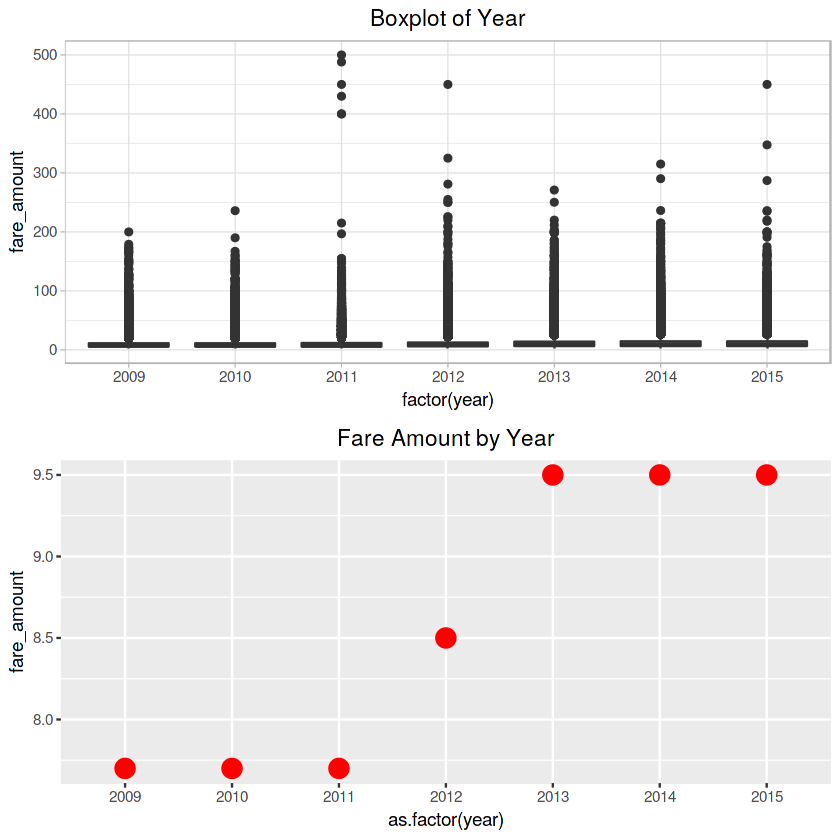

In [29]:
p1=full  %>% filter(sep=="train") %>%
    ggplot(aes(factor(year),y=fare_amount))+
    geom_boxplot()+
    theme_light()+
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle("Boxplot of Year")


p2=full  %>% filter(sep=="train") %>%
    ggplot(aes(as.factor(year), fare_amount))+
    geom_point(stat = "summary", fun.y = "median", col = "red", size = 5)+
    ggtitle("Fare Amount by Year")+
    theme(plot.title = element_text(hjust = .5), legend.position = "bottom")

grid.arrange(p1,p2,nrow=2)

* Median Fare amount by year is increasing up because I think that taxis had to keep prices steady.
* Based on the plot, We would see the month,weekday,time by year

### (2) Month

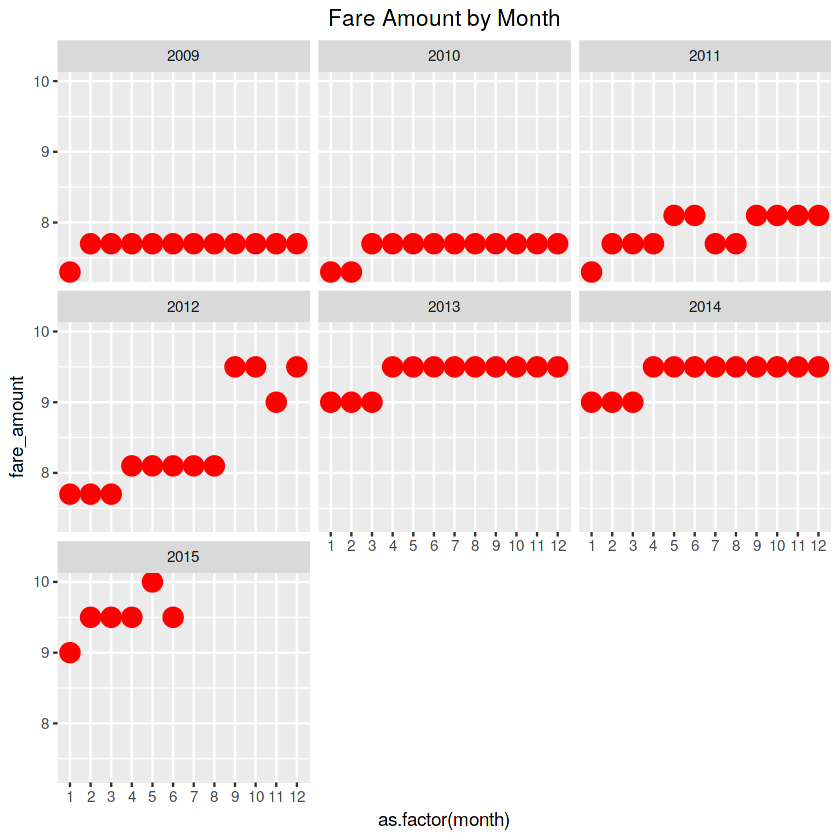

In [30]:
full  %>% filter(sep=="train") %>%
    ggplot(aes(as.factor(month), fare_amount))+
    geom_point(stat = "summary", fun.y = "median", col = "red", size = 5)+
    ggtitle("Fare Amount by Month")+
    theme(plot.title = element_text(hjust = .5), legend.position = "bottom")+
    facet_wrap(~factor(year),nrow=3)

* In september of 2012, The fare_amount has risen sharply.

## (3) Day of Week

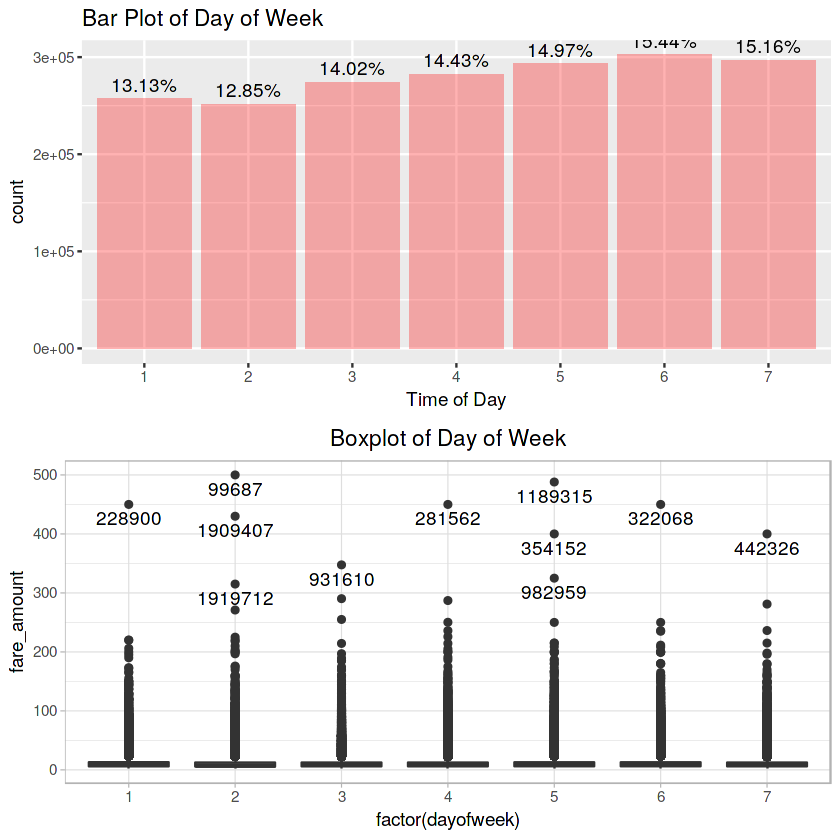

In [31]:
p1=full  %>% filter(sep=="train") %>%
    ggplot(aes(x=factor(dayofweek)))+
    geom_bar(fill="red",alpha=0.3) +
    geom_text(aes(label =scales::percent(..count../sum(..count..))),stat = 'count',vjust = -0.5) +
    ggtitle("Bar Plot of Day of Week") +
    labs(x = "Time of Day")


p2=full  %>% filter(sep=="train") %>%
    ggplot(aes(factor(dayofweek),y=fare_amount))+
    geom_boxplot()+
    geom_text(aes(label = ifelse(fare_amount > 300, rownames(full), ''), vjust = 1.5))+
    theme_light()+
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle("Boxplot of Day of Week")


grid.arrange(p1,p2,nrow=2)

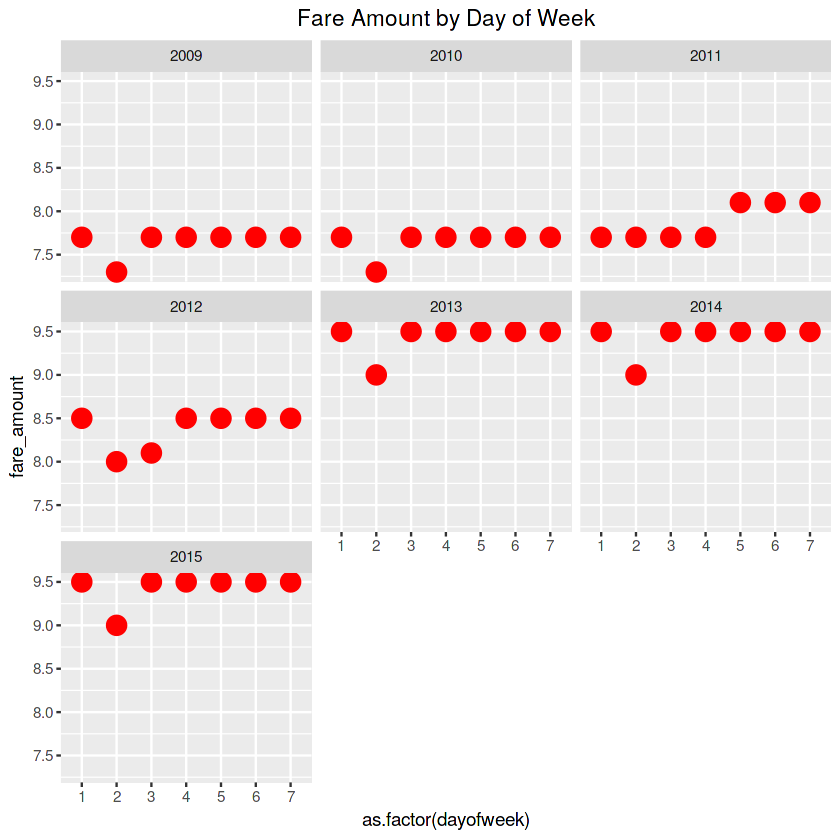

In [32]:
full  %>% filter(sep=="train") %>%
    ggplot(aes(as.factor(dayofweek), fare_amount))+
    geom_point(stat = "summary", fun.y = "median", col = "red", size = 5)+
    ggtitle("Fare Amount by Day of Week")+
    theme(plot.title = element_text(hjust = .5), legend.position = "bottom")+
    facet_wrap(~factor(year),nrow=3)

### (4) Time of Day

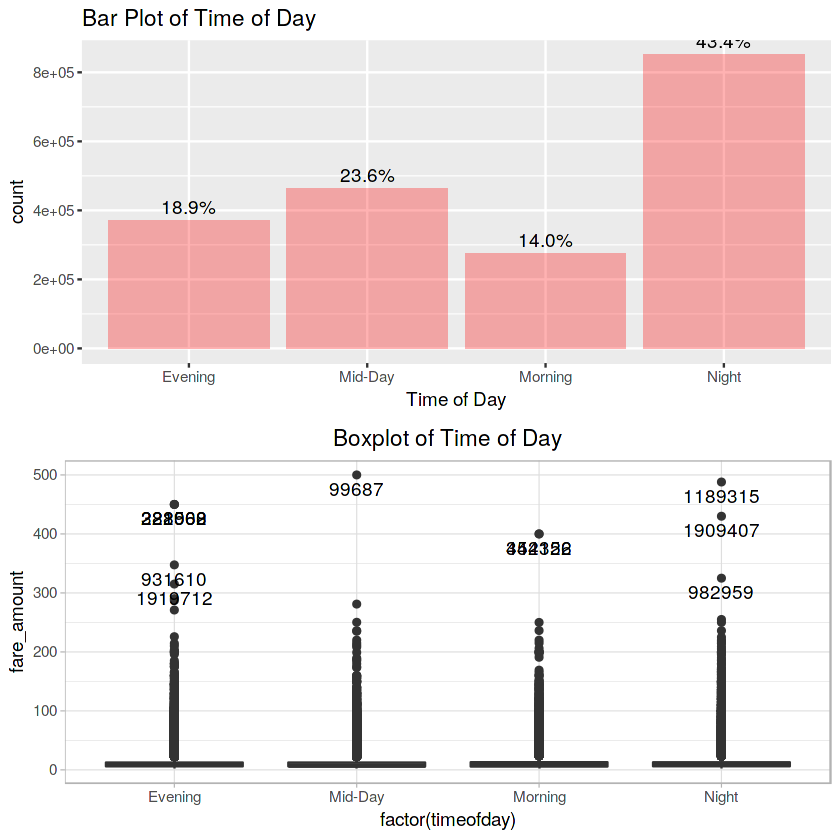

In [33]:
p1 <-full  %>% filter(sep=="train") %>% 
        ggplot(aes(x=factor(timeofday)))+
        geom_bar(fill="red",alpha=0.3) +
        geom_text(aes(label =scales::percent(..count../sum(..count..))),stat = 'count',vjust = -0.5) +
        ggtitle("Bar Plot of Time of Day") +
        labs(x = "Time of Day")

p2=full  %>% filter(sep=="train") %>%
    ggplot(aes(factor(timeofday),y=fare_amount))+
    geom_boxplot()+
    geom_text(aes(label = ifelse(fare_amount > 300, rownames(full), ''), vjust = 1.5))+
    theme_light()+
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle("Boxplot of Time of Day")

grid.arrange(p1,p2,nrow=2)

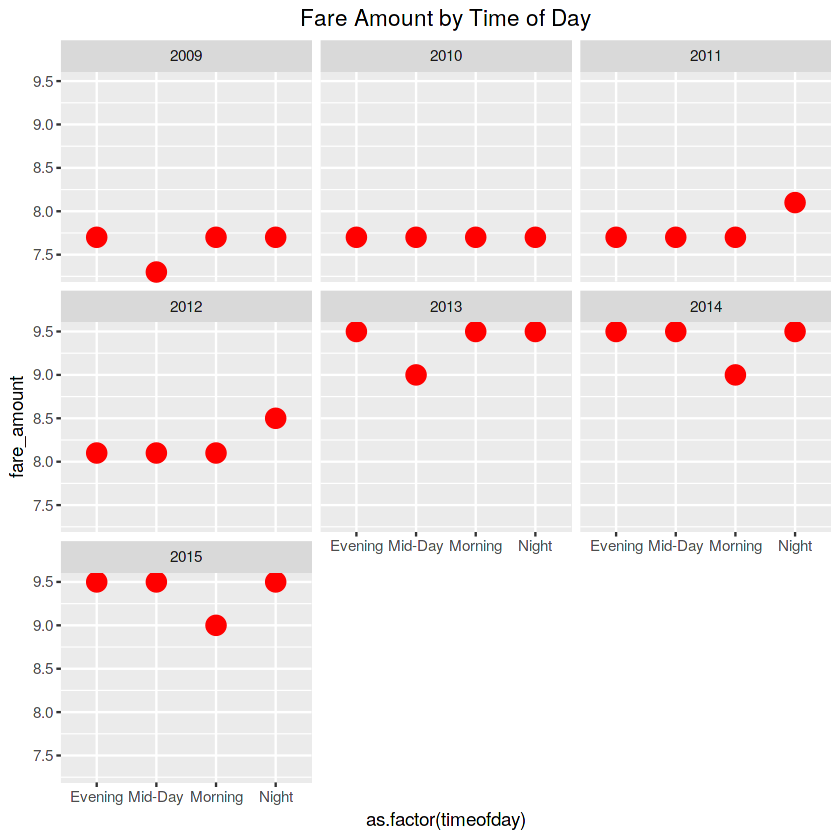

In [34]:
full  %>% filter(sep=="train") %>%
    ggplot(aes(as.factor(timeofday), fare_amount))+
    geom_point(stat = "summary", fun.y = "median", col = "red", size = 5)+
    ggtitle("Fare Amount by Time of Day")+
    theme(plot.title = element_text(hjust = .5), legend.position = "bottom")+
    facet_wrap(~factor(year),nrow=3)

### (5) PassengerCount

In [35]:
summary(full$passenger_count)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.000   1.000   1.000   1.684   2.000   9.000 

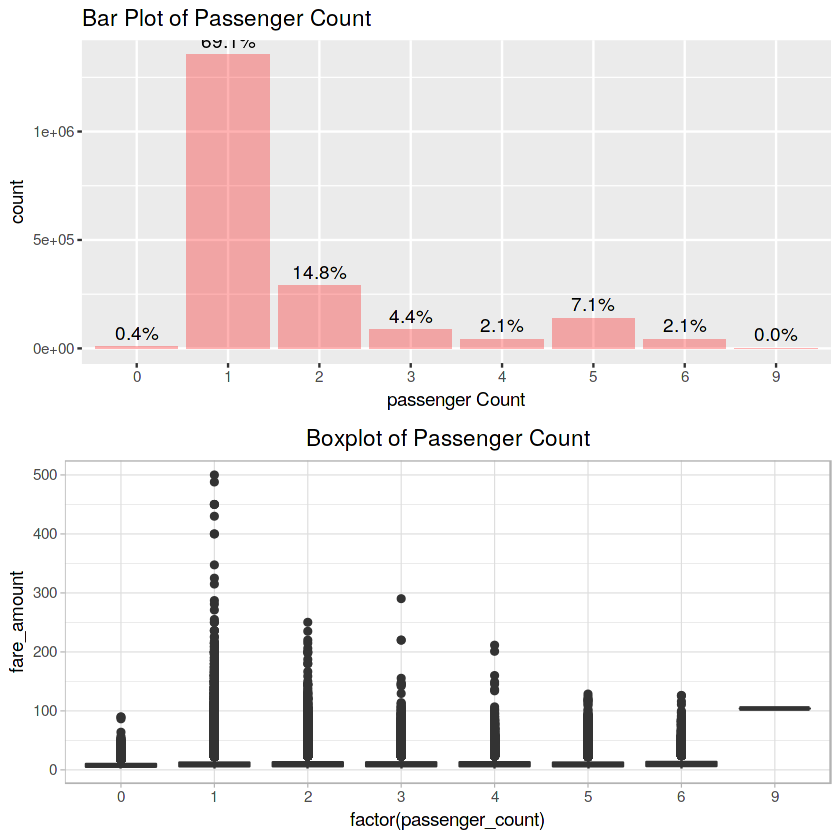

In [36]:
p1 <-full  %>% filter(sep=="train") %>% 
        ggplot(aes(x=factor(passenger_count)))+
        geom_bar(fill="red",alpha=0.3) +
        geom_text(aes(label =scales::percent(..count../sum(..count..))),stat = 'count',vjust = -0.5) +
        ggtitle("Bar Plot of Passenger Count") +
        labs(x = "passenger Count")

p2=full  %>% filter(sep=="train") %>%
    ggplot(aes(factor(passenger_count),y=fare_amount))+
    geom_boxplot()+
    theme_light()+
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle("Boxplot of Passenger Count")

grid.arrange(p1,p2,nrow=2)

In [37]:
full  %>% filter(passenger_count==6)  %>% count(sep)

sep,n
test,177
train,41105


In [38]:
full  %>% filter(passenger_count==9)

key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,sep,year,month,day,dayofweek,hour,timeofday,lat_diff,long_diff,manhattan,dist,cancel
2014-06-24 15:13:00.00000040,104,-74.01578,40.71542,-74.17028,40.70834,9,train,2014,6,24,3,15,Evening,-0.00708,0.1545,0.16158,13.04591,0


**From Driver Rule 54-15(g)  Chapter 54 - Drivers of Taxicabs and Street Hail Liveries (PDF)**

The maximum amount of passengers allowed in a yellow taxicab by law is four (4) in a four (4) passenger taxicab or five (5) passengers in a five (5) passenger taxicab, except that an additional passenger must be accepted if such passenger is under the age of seven (7) and is held on the lap of an adult passenger seated in the rear.

* In Taxi, 0 or 9 passenger is certainly odd values.
  
  but if passenger count doesn't have an effect on the fare then we don't need to worry about this feature. 
  
  We'll do more inspection later.

# Data for Modeling

In [39]:
str(full)

'data.frame':	1967323 obs. of  19 variables:
 $ key              : chr  "2009-06-15 17:26:21.0000001" "2010-01-05 16:52:16.0000002" "2011-08-18 00:35:00.00000049" "2012-04-21 04:30:42.0000001" ...
 $ fare_amount      : num  4.5 16.9 5.7 7.7 5.3 12.1 7.5 16.5 9 8.9 ...
 $ pickup_longitude : num  -73.8 -74 -74 -74 -74 ...
 $ pickup_latitude  : num  40.7 40.7 40.8 40.7 40.8 ...
 $ dropoff_longitude: num  -73.8 -74 -74 -74 -74 ...
 $ dropoff_latitude : num  40.7 40.8 40.8 40.8 40.8 ...
 $ passenger_count  : int  1 1 2 1 1 1 1 1 1 2 ...
 $ sep              : Factor w/ 2 levels "test","train": 2 2 2 2 2 2 2 2 2 2 ...
 $ year             : Factor w/ 7 levels "2009","2010",..: 1 2 3 4 2 3 4 4 4 1 ...
 $ month            : Factor w/ 12 levels "1","2","3","4",..: 6 1 8 4 3 1 11 1 12 9 ...
 $ day              : num  15 5 18 21 9 6 20 4 3 2 ...
 $ dayofweek        : Factor w/ 7 levels "1","2","3","4",..: 2 3 5 7 3 5 3 4 2 4 ...
 $ hour             : num  17 16 0 4 7 9 20 17 13 1 ...
 $ timeofday  

In [40]:
full=full  %>% select(-c(key,passenger_count))

In [41]:
train=full  %>% filter(sep=="train")  %>% select(-sep)
test=full  %>% filter(sep=="test")  %>% select(-sep)

In [42]:
x_train<- model.matrix(~.-1, data = train[,-1]) 

x_test <- model.matrix(~.-1, data = test[,-1])

train_label=train$fare_amount
test_label=test$fare_amount

# Light GBM

In [43]:
library(lightgbm)

Loading required package: R6

Attaching package: ‘lightgbm’

The following objects are masked from ‘package:xgboost’:

    getinfo, setinfo, slice

The following object is masked from ‘package:dplyr’:

    slice



In [44]:
lgb.train = lgb.Dataset(data=x_train, label=train_label)

In [45]:
lgb.grid = list(objective = "regression",
                metric="rmse",
                learning_rate=0.05,
                num_leaves=31,
                feature_fraction = 0.7,
                bagging_fraction = 0.7,
                bagging_freq = 5)

In [46]:
set.seed(42)
# system.time(cv <- lgb.cv(lgb.grid, lgb.train, nrounds = 5000, nfold = 5, stratified = TRUE, eval_freq = 100, early_stopping_rounds = 100))

In [47]:
# best=cv$best_iter
# best=1947

In [48]:
m_lgb = lgb.train(params = lgb.grid, data = lgb.train, nrounds = 1947,nthread=-1,eval_freq=100)

In [49]:
pred_lgb <- predict(m_lgb, x_test)

Warning message in sum(Cover):
“integer overflow - use sum(as.numeric(.))”

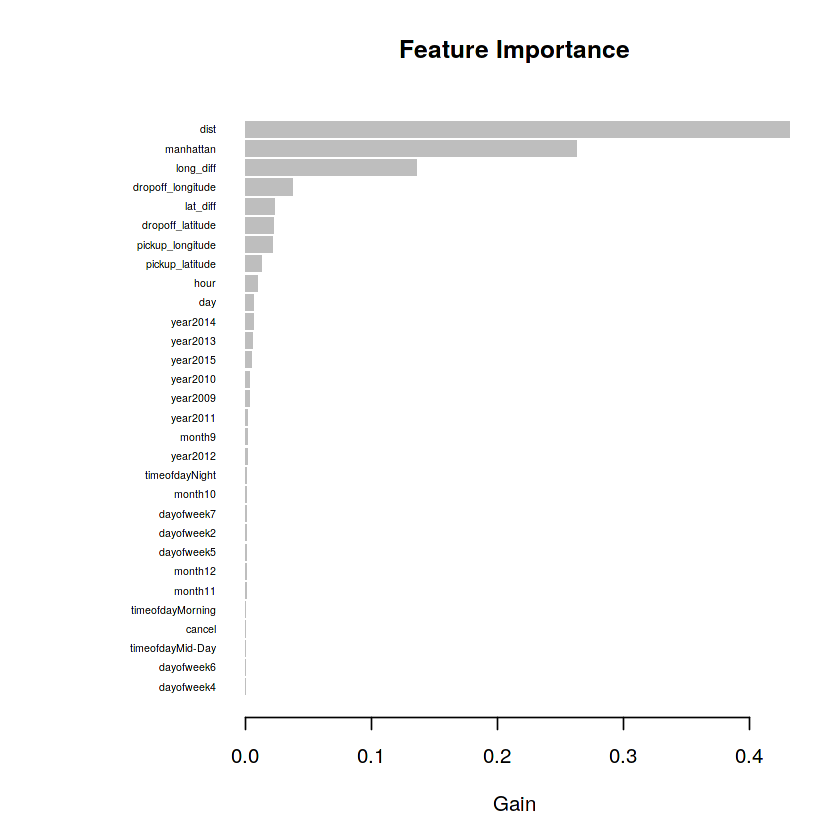

In [50]:
lgb.importance(model = m_lgb) %>% 
  lgb.plot.importance(top_n = 30)

In [51]:
submission_lgb <- read.csv('../input/sample_submission.csv')
submission_lgb$fare_amount <- pred_lgb
write.csv(submission_lgb, file='submission_lgb.csv', row.names = F)